# E23. 다음에 볼 영화 예측하기
* session-based recommendation: 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천
* https://www.youtube.com/watch?v=OpoVuwxGRDI&ab_channel=%EC%96%84%ED%8C%8D%ED%95%9C%EC%BD%94%EB%94%A9%EC%82%AC%EC%A0%84
* https://medium.com/@chrisjune_13837/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582
* https://www.yoochoose.com/
    - https://2015.recsyschallenge.com/challenge.html
    
```
$ sudo apt install p7zip-full
$ 7z x yoochoose-data.7z -oyoochoose-data
```

In [1]:
import os

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
f = open('yoochoose-data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

## Data Preprocess
```
$ pip list | grep pathlib
$ pip install pathlib
```
* (유저-상품 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는) Matrix Factorization 을 사용한다면?: User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 

### Data Load

In [3]:
data_path = Path('yoochoose-data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('yoochoose-data/yoochoose-clicks.dat')

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [6]:
# 유저 수와 아이템 수 확인 (세션 수 900만개, 아이템 수 5만개)

data['SessionId'].nunique(), data['ItemId'].nunique() # (9249729, 52739)

(9249729, 52739)

* session_length: 같은 SessionId를 공유하는 데이터 row의 개수 (해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지)
* SessionId: 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자

In [7]:
session_length = data.groupby('SessionId').size() # 각 세션이 대략 몇 개의 클릭 데이터를 갖는가?
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [9]:
session_length.min(), session_length.max()

(1, 200)

In [10]:
session_length.quantile(0.999) # 99.9%의 세션은 길이 41 이하

41.0

In [11]:
# 길이가 가장 긴 (session_length=200) 하나의 세션만 살펴보기

long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


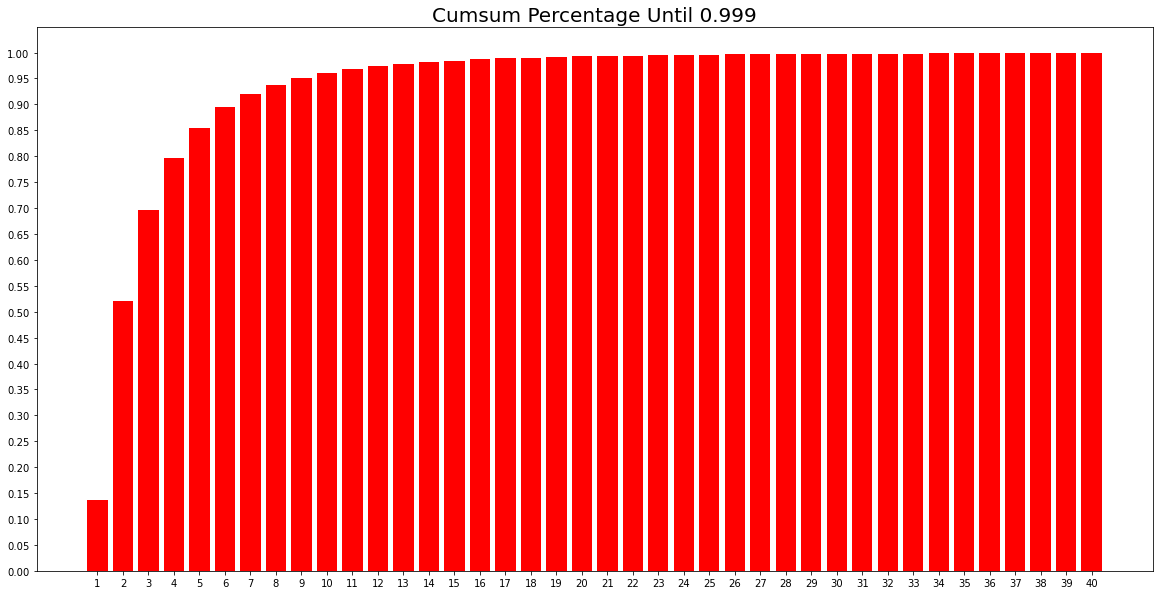

In [12]:
# 시각화

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
# 시간 관련 정보 확인

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest) # oldest~latest: 총 6개월치

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


In [14]:
type(latest) # timestamp 객체는 int와의 사칙연산 안 됨

# timedelta: 날짜끼리의 차이를 구할 때 사용
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### Data Cleaning
* 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로, 길이 1인 세션은 제거
* 너무 적게 클릭된 아이템 역시 이상한 아이템일 가능성이 있으므로, 제거

In [15]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### Train / Valid / Test Split
* session-based recommendation에서는 기간에 따라 train / valid / test 셋 나누기도 함. 사람들의 소비 패턴이 달라지기 때문 (1달 전에 성능이 좋은 모델을 쓰면 지금 맞지 않을 수가 있는데, 추천 시스템은 지금 잘 예측하는 게 중요)

In [17]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## GRU4REC
* https://arxiv.org/pdf/1511.06939v4.pdf

## Data Pipeline
* Session-Parallel Mini-Batch 구현해보기
   
### SessionDataset
* 세션이 시작되는 인덱스를 담는 값과, 세션을 새로 인덱싱한 값을 갖는 클래스 생성

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

* ```click_offsets```: 각 세션이 시작된 인덱스
* ```session_idx```: 각 세션을 인덱싱한 np.array

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [26]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [27]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### SessionDataLoader
* (Python iterator/generator: https://dojang.io/mod/page/view.php?id=2405)
* ```SessionDataLoader()```: SessionDataset 객체를 받아서 Session-Parallel Mini-Batch 만드는 클래스
    - ```__iter__``` 메소드: 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield
    - ```mask```: RNN Cell State를 초기화하는 데 사용

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


## Modeling
### Evaluation Metric
* recall@k: recall의 개념을 확장한 지표 (https://ddiri01.tistory.com/321)
* MAP@k (Mean Average Precision@k): precision의 개념을 확장한 지표
* 순서에 민감한 지표들 (https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)
    - MRR: 정답 아이템이 나온 순번의 역수 값 https://lamttic.github.io/2020/03/20/01.html
    - NDCG
* @k 는 Top K 개를 뜻하는 듯?

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
# 모델에 사용할 하이퍼파라미터를 class 형태로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [35]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

### Inference

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

## 프로젝트: Movielens 영화 SBR
* ```Movielens 1M Dataset```

```
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
$ unzip ml-1m.zip
```

In [37]:
data_path = Path('yoochoose-data/ml-1m')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 데이터 전처리
* 항목별 기본 분석, session length, session time, cleaning
* 이 데이터셋은 session이 UserID 단위로 데이터가 생성되어 있으므로, 이를 session 단위로 어떻게 해석할지에 주의

In [38]:
# 유저 수와 아이템 수 확인

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [39]:
session_length = data.groupby('UserId').size() # 각 세션이 대략 몇 개의 클릭 데이터를 갖는가?
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [40]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [41]:
session_length.min(), session_length.max()

(20, 2314)

In [42]:
session_length.quantile(0.999) # 99.9%의 세션은 길이 1343.181 이하

1343.181000000005

In [43]:
# 길이가 가장 긴 (session_length=max) 하나의 세션만 살펴보기

long_session = session_length[session_length>=1343.181000000005].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
137631,889,1266,3,975247862
137864,889,2430,3,975247862
137889,889,1643,3,975247862
138039,889,3461,3,975247862
138316,889,1193,1,975247862
...,...,...,...,...
138285,889,1322,1,975364486
138292,889,1328,1,975364486
139033,889,2974,2,975364486
137720,889,3047,5,975364518


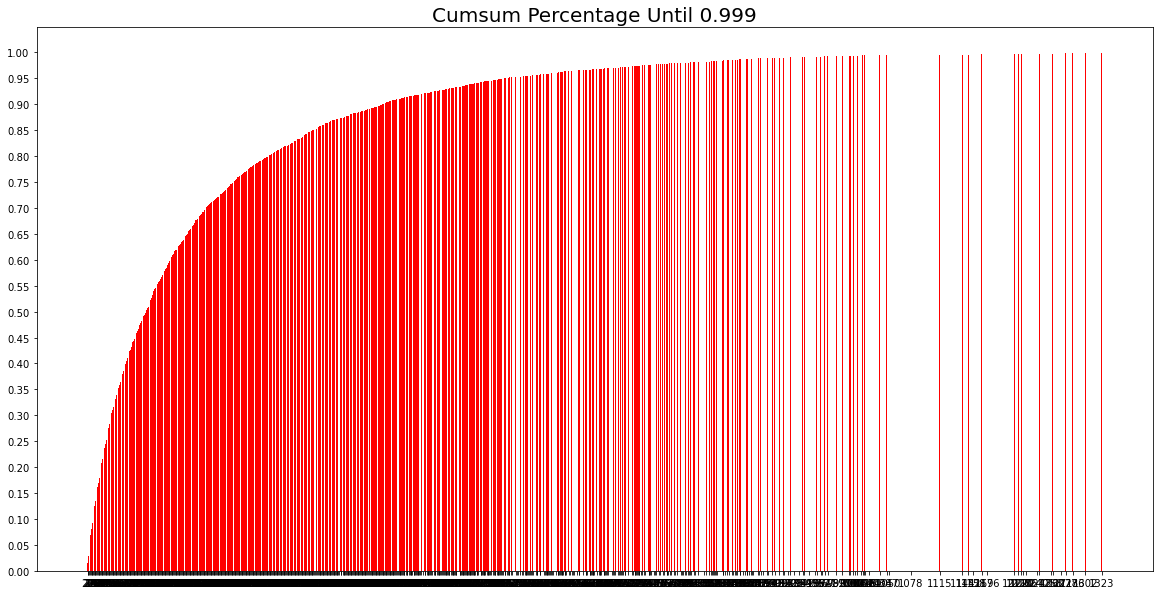

In [44]:
# 시각화

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [45]:
# 시간 관련 정보 확인

# unix timestamp 형식인 Time 컬럼을 datetime 객체로 변경
# https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date
# https://www.kite.com/python/answers/how-to-modify-all-the-values-in-a-pandas-dataframe-column-in-python
data['Time'] = data['Time'].apply(lambda x:dt.datetime.utcfromtimestamp(int(x)))

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest) # oldest~latest: 총 2년 10개월치

2000-04-25 23:05:32
2003-02-28 17:49:50


In [ ]:
# timedelta: 날짜끼리의 차이를 구할 때 사용
'''
month_ago = latest - dt.timedelta(365) # 최근 1년 한정
data = data[data['Time'] > month_ago]
data
'''

In [46]:
# SessionId -> UserId로 변경
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

In [47]:
# 평가를 많이 하거나, 적게 했다고 abuse 여부를 따지긴 어렵지 않나?
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [ ]:
# SessionId -> UserId로 변경
'''
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

# train / valid / test split
data_train, data_test = split_by_date(data, n_days=1)
data_train, data_val = split_by_date(data_train, n_days=1)
'''

In [50]:
data.sort_values(by=['Time'], inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
data.shape

(999611, 4)

In [51]:
data.head()

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
999873,6040,593,5,2000-04-25 23:05:54
1000153,6040,2384,4,2000-04-25 23:05:54
1000007,6040,1961,4,2000-04-25 23:06:17
1000192,6040,2019,5,2000-04-25 23:06:17


In [52]:
data.tail()

,UserId,ItemId,Rating,Time
825793,4958,2399,1,2003-02-28 17:45:38
825438,4958,1407,5,2003-02-28 17:47:23
825724,4958,3264,4,2003-02-28 17:49:08
825731,4958,2634,3,2003-02-28 17:49:08
825603,4958,1924,4,2003-02-28 17:49:50


In [56]:
# split
data_train = data[:700000]
data_val = data[700000:850000]
data_test = data[850000:]

In [57]:
# SessionId -> UserId로 변경
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users (Sessions): {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [58]:
stats_info(data_train, 'train')
stats_info(data_val, 'valid')
stats_info(data_test, 'test')

* train Set Stats Info
	 Events: 700000
	 Users (Sessions): 4870
	 Items: 3408
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2000-11-22 03:15:20

* valid Set Stats Info
	 Events: 150000
	 Users (Sessions): 1348
	 Items: 3351
	 First Time : 2000-11-22 03:15:23
	 Last Time : 2000-12-10 04:52:34

* test Set Stats Info
	 Events: 149611
	 Users (Sessions): 1511
	 Items: 3362
	 First Time : 2000-12-10 04:52:34
	 Last Time : 2003-02-28 17:49:50



In [59]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(data_train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

data_train = indexing(data_train, id2idx)
data_val = indexing(data_val, id2idx)
data_test = indexing(data_test, id2idx)

In [60]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

data_train.to_pickle(save_path / 'train.pkl')
data_val.to_pickle(save_path / 'valid.pkl')
data_test.to_pickle(save_path / 'test.pkl')

### 미니배치 구성
* Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
* Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있다

### 모델 구성

In [61]:
# SessionId -> UserId로 변경
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [62]:
tr_dataset = SessionDataset(data_train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [63]:
tr_dataset.click_offsets

array([     0,     76,    174, ..., 699559, 699682, 700000], dtype=int32)

In [64]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4867, 4868, 4869])

In [65]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999868,6040,573,4,2000-04-25 23:07:36,5
999877,6040,1419,3,2000-04-25 23:07:36,6
999920,6040,213,5,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [66]:
iter_ex = iter(tr_data_loader)

In [67]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  76 171 204]
Label Item Idx are :       [  1  77 172 205]
Previous Masked Input Idx are []


In [68]:
# SessionId -> UserId로 변경
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [69]:
model = create_model(args)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [70]:
# SessionId -> UserId
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [71]:
train_model(model, args)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=7.15]      

	 - Recall@20 epoch 1: 0.079753
	 - MRR@20    epoch 1: 0.017511



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.63] 

	 - Recall@20 epoch 2: 0.142180
	 - MRR@20    epoch 2: 0.033702



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.58]

	 - Recall@20 epoch 3: 0.170555
	 - MRR@20    epoch 3: 0.040239



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00391, train_loss=6.41]

	 - Recall@20 epoch 4: 0.182337
	 - MRR@20    epoch 4: 0.043015



Evaluation:  74%|███████▍  | 432/580 [04:28<01:31,  1.61it/s]

	 - Recall@20 epoch 5: 0.188142
	 - MRR@20    epoch 5: 0.044950



### 모델 테스트

In [73]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, data_test)

Evaluation:  80%|████████  | 464/578 [04:45<01:10,  1.62it/s]

	 - Recall@20: 0.186835
	 - MRR@20: 0.043374



### 조건 1
* learning rate를 높여본다. (0.01) https://bioinformaticsandme.tistory.com/130
* recall이 줄어든다. train_loss는 줄어들다가 늘어난다. 위 블로그의 그래프에서 'very high learning rate' 에 가까운 패턴이다.
* 테스트 결과도 기존 조건보다 좋지 않아 보인다.

In [76]:
args2 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
model2 = create_model(args2)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [77]:
train_model(model2, args2)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.65]

	 - Recall@20 epoch 1: 0.181668
	 - MRR@20    epoch 1: 0.045276



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.55] 

	 - Recall@20 epoch 2: 0.180718
	 - MRR@20    epoch 2: 0.046762



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.4] 

	 - Recall@20 epoch 3: 0.175781
	 - MRR@20    epoch 3: 0.045588



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00391, train_loss=6.62]

	 - Recall@20 epoch 4: 0.172580
	 - MRR@20    epoch 4: 0.045329



Evaluation:  74%|███████▍  | 432/580 [04:35<01:34,  1.57it/s]

	 - Recall@20 epoch 5: 0.168439
	 - MRR@20    epoch 5: 0.044387



In [78]:
test_model(model2, args2, data_test)

Evaluation:  80%|████████  | 464/578 [04:55<01:12,  1.57it/s]

	 - Recall@20: 0.164172
	 - MRR@20: 0.040634



### 조건 2
* learning rate를 낮춰본다. (0.0001)

In [85]:
args3 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.0001, epochs=5, k=20)
model3 = create_model(args3)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_6 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [86]:
train_model(model3, args3)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.42]

	 - Recall@20 epoch 1: 0.049470
	 - MRR@20    epoch 1: 0.010113



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.43]

	 - Recall@20 epoch 2: 0.049479
	 - MRR@20    epoch 2: 0.010150



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=7.39]      

	 - Recall@20 epoch 3: 0.050076
	 - MRR@20    epoch 3: 0.010246



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.36]

	 - Recall@20 epoch 4: 0.051749
	 - MRR@20    epoch 4: 0.010603



Evaluation:  74%|███████▍  | 432/580 [04:55<01:41,  1.46it/s]

	 - Recall@20 epoch 5: 0.053467
	 - MRR@20    epoch 5: 0.010832



In [87]:
test_model(model3, args3, data_test)

Evaluation:  80%|████████  | 464/578 [05:13<01:17,  1.48it/s]

	 - Recall@20: 0.043045
	 - MRR@20: 0.008410



### 조건 3
* drop을 아예 하지 않아본다.
* 학습 시 train_loss나 recall의 추이는 최초 조건과 크게 다르지 않았다.
* 테스트 결과 recall도 최초 조건과 크게 다르지 않았다.

In [79]:
args4 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.0, lr=0.001, epochs=5, k=20)
model4 = create_model(args4)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_4 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [80]:
train_model(model4, args4)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.07]

	 - Recall@20 epoch 1: 0.089247
	 - MRR@20    epoch 1: 0.019759



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.69]

	 - Recall@20 epoch 2: 0.146430
	 - MRR@20    epoch 2: 0.034982



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.53]

	 - Recall@20 epoch 3: 0.172481
	 - MRR@20    epoch 3: 0.040530



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.48]

	 - Recall@20 epoch 4: 0.183268
	 - MRR@20    epoch 4: 0.043173



Evaluation:  74%|███████▍  | 432/580 [04:38<01:35,  1.55it/s]

	 - Recall@20 epoch 5: 0.188422
	 - MRR@20    epoch 5: 0.044767



In [81]:
test_model(model4, args4, data_test)

Evaluation:  80%|████████  | 464/578 [04:53<01:12,  1.58it/s]

	 - Recall@20: 0.186591
	 - MRR@20: 0.043538



### 조건 4
* drop을 아예 하지 않았을 때, 결과가 최초 조건과 별로 차이나지 않았으므로 drop 비율을 늘려본다. (0.3)

In [82]:
args5 = Args(data_train, data_val, data_test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.001, epochs=5, k=20)
model5 = create_model(args5)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3408)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519000    
_________________________________________________________________
dropout_5 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (256, 3408)               173808    
Total params: 692,808
Trainable params: 692,808
Non-trainable params: 0
_________________________________________________________________


In [83]:
train_model(model5, args5)

Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0, train_loss=7.21]      

	 - Recall@20 epoch 1: 0.070927
	 - MRR@20    epoch 1: 0.015583



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.89]

	 - Recall@20 epoch 2: 0.127125
	 - MRR@20    epoch 2: 0.030043



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00391, train_loss=6.6] 

	 - Recall@20 epoch 3: 0.161929
	 - MRR@20    epoch 3: 0.038242



Train:   0%|          | 0/2715 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.56]

	 - Recall@20 epoch 4: 0.175655
	 - MRR@20    epoch 4: 0.041458



Evaluation:  74%|███████▍  | 432/580 [04:31<01:32,  1.59it/s]

	 - Recall@20 epoch 5: 0.182373
	 - MRR@20    epoch 5: 0.043256



In [84]:
test_model(model5, args5, data_test)

Evaluation:  80%|████████  | 464/578 [04:53<01:12,  1.58it/s]

	 - Recall@20: 0.181152
	 - MRR@20: 0.041545

